# Machine Learning LAB 2A: Perceptrons

Course 2025/26: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Classification of Stayed/Churned Customers

The Customer Churn table contains information on all 3,758 customers from a Telecommunications company in California in Q2 2022. Companies are naturally interested in churn, i.e., in which users are likely to switch to another company soon to get a better deal, and which are more loyal customers.

The dataset contains three features:
- **Tenure in Months**: Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age

The aim of the task is to predict if a customer will churn or not based on the three features.

---

## Import all the necessary Python libraries and load the dataset

### The Dataset
The dataset is a `.csv` file containing three input features and a label. Here is an example of the first 4 rows of the dataset: 

<center>

Tenure in Months | Monthly Charge | Age | Customer Status |
| -----------------| ---------------|-----|-----------------|
| 9 | 65.6 | 37 | 0 |
| 9 | -4.0 | 46 | 0 |
| 4 | 73.9 | 50 | 1 |
| ... | ... | ... | ... |

</center>

Customer Status is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [1]:
import numpy as np
import random as rnd
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    #permute the data
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffle the data
    X = data_train.iloc[:, 0:3].values # Get first three columns as the input
    Y = data_train.iloc[:, 3].values # Get the third column as the label
    Y = 2*Y-1 # Make sure labels are -1 or 1 (0 --> -1, 1 --> 1)
    return X,Y, data_train

# Load the dataset
X, Y, data_train = load_dataset('data/telecom_customer_churn_cleaned.csv')

In [2]:
data_train

,Tenure in Months,Monthly Charge,Age,Customer Status
0,20,19.70,62,0
1,8,81.25,66,1
2,11,48.55,43,1
3,2,70.00,31,1
4,2,49.40,27,1
...,...,...,...,...
3752,4,98.10,34,1
3753,72,110.80,69,0
3754,19,24.90,20,0
3755,64,47.85,61,1


In [3]:
print("Inputs: \n", X)
print("Labels: \n", Y)

Inputs: 
 [[20.   19.7  62.  ]
 [ 8.   81.25 66.  ]
 [11.   48.55 43.  ]
 ...
 [19.   24.9  20.  ]
 [64.   47.85 61.  ]
 [37.   90.6  42.  ]]
Labels: 
 [-1  1  1 ... -1  1 -1]


We are going to differentiate (classify) between **class "1" (churned)** and **class "-1" (stayed)**

## Divide the data into training and test sets

In [4]:
# Compute the splits
m_training = int(0.75*X.shape[0])

# m_test is the number of samples in the test set (total-training)
m_test =  X.shape[0] - m_training
X_training =  X[:m_training]
Y_training =  Y[:m_training]
X_test =   X[m_training:]
Y_test =  Y[m_training:]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("Number of churned users in test:", np.sum(Y_test==-1))
print("Number of loyal users in test:", np.sum(Y_test==1))

# Standardize the input matrix -> standardize datas 
# The transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training =  scaler.transform(X_training) # standardize datas 
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test =  scaler.transform(X_test) # standardize test_set basing on train set -> this is because MODEL do not know TEST during training
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Number of samples in the train set: 2817
Number of samples in the test set: 940
Number of churned users in test: 479
Number of loyal users in test: 461
Mean of the training input data: [-0.  0. -0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [0.0575483  0.05550169 0.0073833 ]
Std of the test input data: [0.98593187 0.97629659 1.00427583]


We will use **homogeneous coordinates** to describe all the coefficients of the model.

_Hint:_ The conversion can be performed with the function $hstack$ in $numpy$.

In [5]:
def to_homogeneous(X_training, X_test):
    df_train = pd.DataFrame(X_training)
    df_train.insert(0, "bias", 1)
    df_test = pd.DataFrame(X_test)
    df_test.insert(0, "bias", 1)
    # Convert back to NumPy arrays if you want to return arrays
    Xh_training = df_train.values
    Xh_test     = df_test.values
    
    return Xh_training, Xh_test

In [6]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Training set in homogeneous coordinates:
[[ 1.         -0.3798618  -1.57020044  0.85174963]
 [ 1.         -0.87925308  0.47180292  1.08667766]
 [ 1.         -0.75440526 -0.6130632  -0.26415851]
 [ 1.         -1.12894873  0.09856916 -0.96894261]
 [ 1.         -1.12894873 -0.58486332 -1.20387064]
 [ 1.          1.78416712  1.39908145  0.08823353]
 [ 1.         -0.7960212  -1.0990965  -0.32289052]
 [ 1.          0.20276137 -0.39907585 -0.96894261]
 [ 1.         -0.62955744  0.63934341  0.96921364]
 [ 1.         -0.87925308  1.13201197 -0.02923048]]


## Deterministic perceptron

Now **complete** the function *perceptron*. <br>
The **perceptron** algorithm **does not terminate** if the **data** is not **linearly separable**, therefore your implementation should **terminate** if it **reached the termination** condition seen in class **or** if a **maximum number of iterations** have already been run, where one **iteration** corresponds to **one update of the perceptron weights**. In case the **termination** is reached **because** the **maximum** number of **iterations** have been completed, the implementation should **return the best model** seen throughout.

The current version of the perceptron is **deterministic**: we use a fixed rule to decide which sample should be considered (e.g., the one with the lowest index).

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model (or the latest, if the termination condition is reached)
- $best\_error$: the *fraction* of misclassified samples for the best model

In [7]:
def count_errors(current_w, X, Y):
    # This function:
    # -computes the number of misclassified samples
    # -returns the indexes of all misclassified samples
    # -if there are no misclassified samples, returns -1 as index
    # TODO: write the function

    n = 0
    index = []
    for i in range(X.shape[0]):
        y = np.sign(np.dot(X[i,:], current_w))
        if (y != Y[i]):
            n += 1 
            index.append(i)
    if (len(index) == 0):
        index.append(-1)
        return n, index
    else:
        return n, index
    
def perceptron_fixed_update(current_w, X, Y): # For this deterministc version, we choose only the first misclassified point to update

    new_w=current_w
    n, idx = count_errors(current_w, X, Y)
    # Choose the first misclassified sample
    if (n > 0):
        new_w = current_w + Y[idx[0]] * X[idx[0],:]    
    return new_w

def perceptron_no_randomization(X, Y, max_num_iterations):
    best_error = 1e10
    current_w = np.zeros(X.shape[1])
    best_w = current_w.copy()
    
    for i in range(max_num_iterations):
        # Vectorized ERM computation
        predictions = np.sign(X @ current_w)
        erm = np.mean(predictions != Y)
        
        # Deterministic update: first misclassified point
        current_w = perceptron_fixed_update(current_w, X, Y)

        # Track best solution
        if erm < best_error:
            best_error = erm
            best_w = current_w.copy()

        # Stop early if perfect classification
        if best_error == 0:
            break
     
    return best_w, best_error


Now we use the implementation above of the perceptron to learn a model from the training data using 30 iterations and print the error of the best model we have found.

In [8]:
w_found, error = perceptron_no_randomization(X_training,Y_training, 30)
print("Training Error of perceptron (30 iterations): " + str(error))
w_found2, error2 = perceptron_no_randomization(X_training,Y_training, 100)
print("Training Error of perceptron (100 iterations): " + str(error2))

Training Error of perceptron (30 iterations): 0.2751153709620163
Training Error of perceptron (100 iterations): 0.2751153709620163


Now use the best model $w\_found$ to **predict the labels for the test dataset** and print the fraction of misclassified samples in the test set (the test error that is an estimate of the true loss).

In [9]:
def loss_estimate(w,X,Y):
    t_loss_estimate = 0
    for i in range(X.shape[0]):
        if (np.sign(np.dot(X[i,:],w)) != Y[i]):
            t_loss_estimate += 1
        
    t_loss_estimate = t_loss_estimate / X.shape[0]
    return t_loss_estimate


true_loss_estimate =  loss_estimate(w_found, X_test, Y_test)       # Error rate on the test set
true_loss_estimate2 =  loss_estimate(w_found2, X_test, Y_test) 
    
print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))
print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate2))

Test Error of perceptron (30 iterations): 0.31063829787234043
Test Error of perceptron (100 iterations): 0.31063829787234043


### Randomized perceptron

Implement the correct randomized version of the perceptron such that at each iteration the algorithm picks a random misclassified sample and updates the weights using that sample. The functions will be very similar, except for some minor details.

In [10]:
def perceptron_randomized_update(current_w, X, Y):
    # TODO: write the perceptron update function

    new_w=current_w
    n, idx = count_errors(current_w, X, Y)
    # Choose the first misclassified sample
    if (n > 0):
        random = np.random.randint(0, n)
        #2 random = rnd.sample(sorted(idx), 1)[0]
        new_w = current_w + Y[idx[random]] * X[idx[random],:]    

    return new_w

def perceptron_with_randomization(X, Y, max_num_iterations):
    best_error = 1e10
    current_w = np.zeros(X.shape[1])
    best_w = current_w.copy()
    
    for i in range(max_num_iterations):
        # Vectorized ERM computation
        predictions = np.sign(X @ current_w)
        erm = np.mean(predictions != Y)
        
        # Deterministic update: first misclassified point
        current_w = perceptron_randomized_update(current_w, X, Y)

        # Track best solution
        if erm < best_error:
            best_error = erm
            best_w = current_w.copy()

        # Stop early if perfect classification
        if best_error == 0:
            break
     
    return best_w, best_error


Now test the correct version of the perceptron using 30 iterations and print the error of the best model we have found.

In [11]:
# Now run the perceptron for 30 iterations
w_found, error = perceptron_with_randomization(X_training, Y_training, 30)
w_found2, error2 = perceptron_with_randomization(X_training, Y_training, 100)
print("Training Error of perceptron (30 iterations): " + str(error))
print("Training Error of perceptron (100 iterations): " + str(error2))

true_loss_estimate =  loss_estimate(w_found, X_test, Y_test)       # Error rate on the test set
true_loss_estimate2 =  loss_estimate(w_found2, X_test, Y_test) 

print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))
print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate2))

Training Error of perceptron (30 iterations): 0.25097621583244584
Training Error of perceptron (100 iterations): 0.24565140220092296
Test Error of perceptron (30 iterations): 0.44574468085106383
Test Error of perceptron (100 iterations): 0.2765957446808511


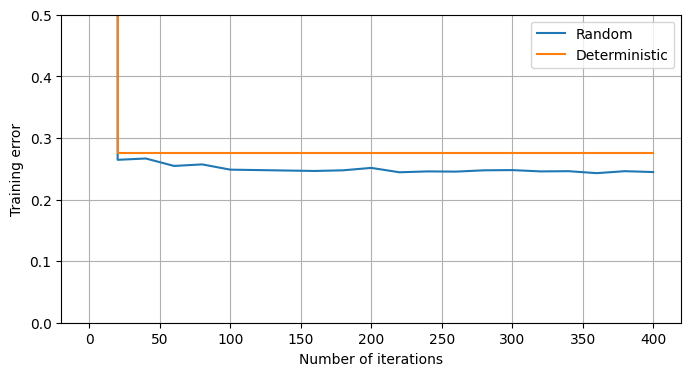

In [13]:
# TODO Plot the loss with respect to the number of iterations (up to 1000)
# Plot the loss with respect to the number of iterations
plt.figure(figsize=(8,4))

num_iters = np.arange(0, 401,20)
errors_rand = []
errors_det = []

for num_iter in num_iters:
    _, error_rand = perceptron_with_randomization(X_training, Y_training, num_iter)
    _, error_det = perceptron_no_randomization(X_training, Y_training, num_iter)
    errors_rand.append(error_rand)
    errors_det.append(error_det)

plt.plot(num_iters, errors_rand, label='Random')
plt.plot(num_iters, errors_det, label='Deterministic')
plt.xlabel('Number of iterations')
plt.ylabel('Training error')
plt.grid()
plt.ylim([0,0.5])
plt.legend()
plt.show()